In [0]:
import numpy as np
from google.colab import drive

from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import math

%matplotlib inline
plt.rcParams["figure.figsize"] = 12.8, 9.6

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [166]:
!ls "/content/gdrive/My Drive/Colab Notebooks/orientation"

20-march	  box_1_output.npy  box_3_output.npy
box_0_output.npy  box_2_output.npy  box_4_output.npy


In [0]:
def load_point_cloud():
  df = np.load("/content/gdrive/My Drive/Colab Notebooks/orientation/20-march/30/point_cloud_err_2.npy")
  return df.T

In [207]:
points = load_point_cloud()
# transpose the data
points = points.T
print(points)
DEPTH_SCALE = 2000
CUT_OFF_SCALE = 1

[[3.83000000e+02 3.83000000e+02 3.83000000e+02 ... 5.54000000e+02
  5.54000000e+02 5.54000000e+02]
 [6.47000000e+02 6.48000000e+02 6.49000000e+02 ... 1.05500000e+03
  1.05600000e+03 1.05700000e+03]
 [3.10000002e-01 3.10000002e-01 3.10000002e-01 ... 2.63000011e-01
  2.63000011e-01 2.63000011e-01]]


In [0]:
def filter_input_data_for_outliers(points):
  points[2] = points[2]*DEPTH_SCALE
  std_dev = np.std(points[2])
  mean = np.mean(points[2])

  print("standard deviation = ", std_dev)
  print("mean = ", mean)
  print("array shape = ", points.shape)

  filtered_array = np.array([])
  for index in range(len(points[2])):
    if points[2][index] < (mean + std_dev*CUT_OFF_SCALE) and points[2][index] > (mean - std_dev*CUT_OFF_SCALE):
      filtered_array = np.append(filtered_array, points[:, index], axis=0)
  
  # print("flat array length = ", len(filtered_array)/3)
  filtered_array = np.reshape(filtered_array, (int(len(filtered_array)/3), 3))
  print("new array shape = ", filtered_array.T.shape)
  return filtered_array.T

In [209]:
filtered_points = filter_input_data_for_outliers(points)
print(filtered_points)

standard deviation =  160.92668085367345
mean =  517.0713207855742
array shape =  (3, 21488)
new array shape =  (3, 19663)
[[ 383.          383.          383.         ...  554.
   554.          554.        ]
 [ 647.          648.          649.         ... 1055.
  1056.         1057.        ]
 [ 620.00000477  620.00000477  620.00000477 ...  526.00002289
   526.00002289  526.00002289]]


In [0]:
def distance(X,p):
    plane = p[0:3]
    distance = (plane*X.T).sum(axis=1) - p[3]
    return distance / np.linalg.norm(plane)

def residuals(params, signal, X):
    return distance(X, params)

In [0]:
def get_initial_plane_coefficient():
    """ 
    plane equation is aX + bY + cZ = d
    plane_coeff = [a, b, c, d]
    """
    plane_coeff = [0.506645455682, -0.185724560275, -1.43998120646, 1.37626378129]
    
    return plane_coeff

In [0]:
plane_coeff = get_initial_plane_coefficient()

In [0]:
# solution = leastsq(residuals, plane_coeff, args=(None, points))[0]
solution = leastsq(residuals, plane_coeff, args=(None, filtered_points))[0]

In [214]:
print("a = ", solution[0], "b = ", solution[1], "c = ", solution[2], "d = ", solution[3])

a =  3.2482625098789986 b =  -7.292866588159591 c =  -26.05494656516236 d =  -19607.641608262013


In [215]:
print("old offset = ", (distance(points, plane_coeff)**2).sum())
print("new offset =  ", (distance(points, solution)**2).sum())

old offset =  4672062459.0679035
new offset =   551089264.9497105


In [0]:
def get_plane_point_cloud(a, b, c, d):
    if a != 0:
        x = np.linspace(0,500,10)
    else:
        x = np.linspace(0,0,10)
        
    if b != 0:
        y = np.linspace(0,500,10)
    else:
        y = np.linspace(0,0,10)
    
    if c != 0:
        X,Y = np.meshgrid(x,y)
        Z = (d - (a*X + b*Y))/c
    else:
        z = np.linspace(0,0,10)
        X,Z = np.meshgrid(x, z)
        Y = (d - (a*X + c*Z))/b

    return X, Y, Z

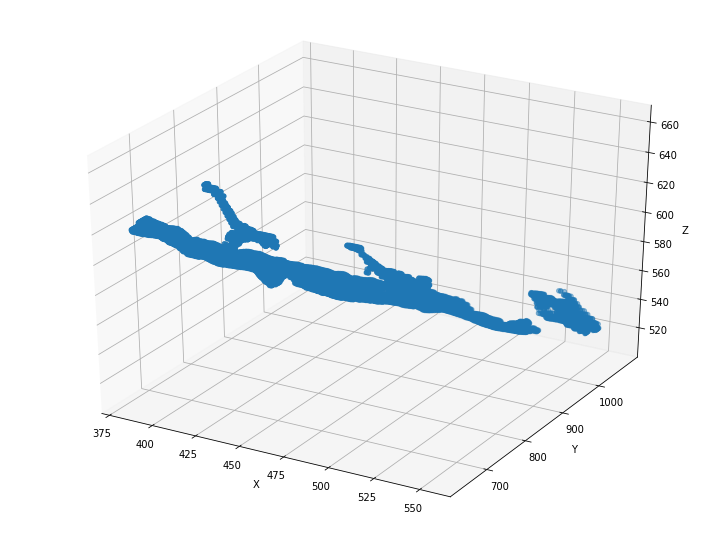

In [217]:
fig = plt.figure()

# ax = plt.axes(projection='3d')
ax = fig.gca(projection='3d')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# original plot point cloud
# xs = points[0]
# ys = points[1]
# zs = points[2]

# point cloud excluding outliers
xs = filtered_points[0]
ys = filtered_points[1]
zs = filtered_points[2]

ax.scatter(xs, ys, zs, linewidth=1)

# # plot inferred plan
X, Y, Z = get_plane_point_cloud(solution[0], solution[1], solution[2], solution[3])
# ax.plot_surface(X, Y, Z, alpha=1, cmap='autumn')

# plot reference plan
ref_plane_a = 0
ref_plane_b = 0
ref_plane_c = 1
ref_plane_d = 1

X, Y, Z = get_plane_point_cloud(ref_plane_a, ref_plane_b, ref_plane_c, ref_plane_d)
# ax.plot_surface(X, Y, Z, alpha=0, cmap='winter')

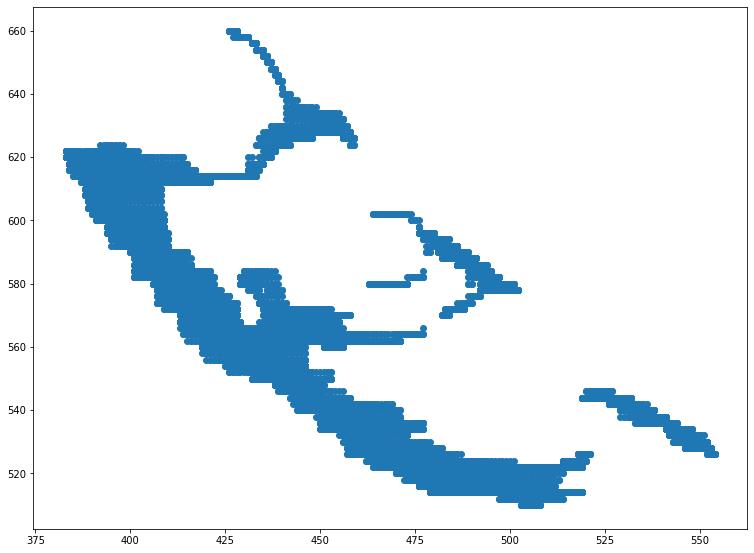

In [225]:
plt.scatter(filtered_points[0], filtered_points[2])

In [0]:
def calculate_angle_between_planes(a1, b1, c1, a2, b2, c2):
    n = abs(a1*a2 + b1*b2 + c1*c2)
    d1 = math.sqrt(a1*a1 + b1*b1 + c1*c1)
    d2 = math.sqrt(a2*a2 + b2*b2 + c2*c2)
    cos_angle = round(n/(d1*d2), 10)
    print("n = ", n, " d1 = ", d1, " d2 = ", d2, "angle in radians = ", cos_angle)
    angle = math.degrees(math.acos(cos_angle))
    return angle

In [219]:
print("Inferred ->  a = ", solution[0], "b = ", solution[1], "c = ", solution[2], "d = ", solution[3])
print("Reference -> a = ", ref_plane_a, "b = ", ref_plane_b, "c = ", ref_plane_c, "d = ", ref_plane_d)

angle = calculate_angle_between_planes(solution[0], solution[1], solution[2], ref_plane_a, ref_plane_b, ref_plane_c)
print("angle between plan is %d degrees"%(angle))

Inferred ->  a =  3.2482625098789986 b =  -7.292866588159591 c =  -26.05494656516236 d =  -19607.641608262013
Reference -> a =  0 b =  0 c =  1 d =  1
n =  26.05494656516236  d1 =  27.250639495601675  d2 =  1.0 angle in radians =  0.9561223901
angle between plan is 17 degrees
